<a href="https://colab.research.google.com/github/rahulrajesh23/fake-image-detector/blob/main/Fake_image_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
We implement some classifiers to predict whether or not images of cats are "deepfakes", i.e., generated by AI. (I used SD 1.5, and down-sampled to match CIFAR-10, which we use for real images.)

We will use the functionality of PyTorch, HuggingFace "transformers" library for getting pretrained models, scikit-learn (for cross validation utility and for baseline logistic regression), matplotlib for visualization.

In [ ]:
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


import torchvision.utils as vutils
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Turning off annoying convergence warnings from sklearn
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

You can download the data file here:
 https://elearn.ucr.edu/courses/125165/files/12619307/download?download_frd=1
You'll have to make them available locally or upload them to your colab instance.

Data shapes before flattening:
X: torch.Size([2000, 3, 32, 32])
y: torch.Size([2000])
X shape after flattening: torch.Size([2000, 3072])



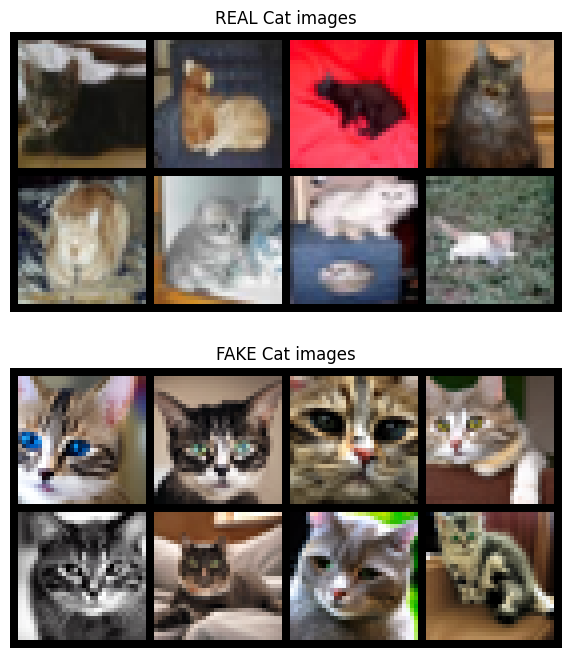

In [ ]:
# Load dataset and visualize
X, y = torch.load('hw2_data.pt')

print('Data shapes before flattening:')
print('X:', X.shape)  # 2000, 3, 32, 32, 2000 images, channel, height width
print('y:', y.shape)  # 2000 binary labels 0 is real, 1 is fake

# Printing examples from each class
grid = vutils.make_grid(X[y==0][:8], nrow=4, padding=2, normalize=True)
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
axs[0].axis('off')
axs[0].set_title('REAL Cat images')
axs[0].imshow(grid.numpy().transpose((1, 2, 0)))

grid = vutils.make_grid(X[y==1][:8], nrow=4, padding=2, normalize=True)
axs[1].axis('off')
axs[1].set_title('FAKE Cat images')
axs[1].imshow(grid.numpy().transpose((1, 2, 0)))


X = X.flatten(start_dim=1)  # From now on, we work with the flattened vector
print(f"X shape after flattening: {X.shape}\n")

In [ ]:
# Using scikit-learn logistic regression (with default hyper-parameters)
# with 5-fold CV to get the train and validation accuracies
# for a simple linear classifier - a good baseline for our MLP
n_folds = 5
val_accs = []  # to store validation accuracy for each fold
train_accs = []  # to store training accuracy for each fold

# iterating over folds, using "shuffle=True", as datapoints are not shuffled
kf = KFold(n_splits=n_folds, shuffle=True)

for train_index, val_index in kf.split(X):

    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # Fitting model on training data

    logistic_model = LogisticRegression()
    logistic_model.fit(X_train_fold, y_train_fold)

    # Computing and storing accuracy on train data

    train_acc = accuracy_score(y_train_fold, logistic_model.predict(X_train_fold))
    train_accs.append(train_acc)

    # Computing and storing accuracy on validation data

    val_acc = accuracy_score(y_val_fold, logistic_model.predict(X_val_fold))
    val_accs.append(val_acc)

train_std, train_mean = torch.std_mean(torch.tensor(train_accs))
val_std, val_mean = torch.std_mean(torch.tensor(val_accs))

# Standard error is standard deviation / sqrt(n), it is more typical to report this
rootn = torch.sqrt(torch.tensor(n_folds))  # n is number of folds
print(f'Train Accuracy and standard error:\t {train_mean:.3f} +/- {train_std / rootn:.3f}')
print(f'Validation Accuracy and standard error:\t {val_mean:.3f} +/- {val_std / rootn:.3f}')

Train Accuracy and standard error:	 0.986 +/- 0.001
Validation Accuracy and standard error:	 0.619 +/- 0.004


## Defining the model

- Using Linear layers with ReLU activations for the hidden layers
- 2 layers of hidden units. First layer has 128 hidden units, second layer has 64 hidden units.
- Output represents *binary* logits

In [ ]:
class MyMLP(nn.Module):
    def __init__(self):
        super(MyMLP, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 128)  # input size: 32*32*3, hidden layer output(1) size: 128
        self.fc2 = nn.Linear(128, 64)  # input size: 128, hidden layer(2) output size: 64
        self.fc3 = nn.Linear(64, 2)  # input size: 64, final output size: 2 (logits representing real, fake image classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


## Train function


In [ ]:
# Function to train the model
# (called for each hyper-parameter and fold)

def train(model, train_loader, val_loader, n_epochs, optimizer, criterion, verbose=False):
    """Training the model using data from train_loader over n_epochs,
    using a Pytorch "optimizer" object (SGD in this case)
    and "criterion" as the loss function (CrossEntropyLoss in this case).
    """
    for epoch in range(n_epochs):
        model.train()  # Setting the model to training mode
        train_loss = 0.0

        # Training loop
        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Zero the parameter gradients

            # Forward pass
            outputs = model(inputs).softmax(dim=1)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        # Compute average training loss for the epoch
        train_loss /= len(train_loader.dataset)

        # Validation loop
        model.eval()  # Setting the model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

        # Compute average validation loss for the epoch
        val_loss /= len(val_loader.dataset)

        if verbose:
            print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')



Loop over hyper-parameters and do 5-fold cross-validation for each setting, saving the train and validation mean accuracy and standard error.

In [ ]:
# Performing cross-validation to get train/val accuracy
# for all hyper-parameter settings in the list below.
learning_rates = [0.001, 0.01, 0.1]
weight_decays = [0., 0.01]
batch_size = 50
n_epochs = 100
n_folds = 5

results = []
for lr in learning_rates:
    for wd in weight_decays:
        val_accs = []  # to store validation accuracy for each fold
        train_accs = []  # to store training accuracy for each fold

        # iterating over folds, using "shuffle=True" as datapoints are not shuffled
        kf = KFold(n_splits=n_folds, shuffle=True)

        for train_index, val_index in kf.split(X):



            # Splitting data into train and validation

            X_train_fold, X_val_fold = X[train_index], X[val_index]
            y_train_fold, y_val_fold = y[train_index], y[val_index]


            # Creating data loaders to pass to training loop

            train_dataset = TensorDataset(torch.tensor(X_train_fold), torch.tensor(y_train_fold))
            val_dataset = TensorDataset(torch.tensor(X_val_fold), torch.tensor(y_val_fold))


            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

            # Initializing model, criterion (Cross entropy loss), and optimizer (SGD with various hyperparameters)

            model = MyMLP()
            criterion = nn.CrossEntropyLoss()
            optimizer = SGD(model.parameters(), lr=lr, weight_decay=wd)


            # Calling the training function
            train(model, train_loader, val_loader, n_epochs, optimizer, criterion, verbose=False)

            with torch.no_grad():
                # Using the trained model to estimate train/val accuracy
                # (Our model outputs logits, argmax is good to get the class prediction corresponding to max logit)

                # Choosing class with max logit
                train_predictions = torch.argmax(model(torch.tensor(X_train_fold)), axis=1)
                val_predictions = torch.argmax(model(torch.tensor(X_val_fold)), axis=1)


                train_acc = accuracy_score(y_train_fold, train_predictions)
                train_accs.append(train_acc)

                val_acc = accuracy_score(y_val_fold, val_predictions)
                val_accs.append(val_acc)


        # For each hyper-parameter, I'm storing the parameter values and the mean and standard error of accuracy in a list in "results".
        train_std, train_mean = torch.std_mean(torch.tensor(train_accs))
        val_std, val_mean = torch.std_mean(torch.tensor(val_accs))
        rootn = torch.sqrt(torch.tensor(n_folds))  # n is number of folds
        train_se, val_se = train_std / rootn, val_std / rootn
        # Storing learning rate, weight decay value, train mean accuracy, standard error, val mean accuracy, standard error
        results.append((lr, wd, train_mean.item(), train_se.item(), val_mean.item(), val_se.item()))


<ipython-input-44-82be80b692ea>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train_fold), torch.tensor(y_train_fold))
<ipython-input-44-82be80b692ea>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_dataset = TensorDataset(torch.tensor(X_val_fold), torch.tensor(y_val_fold))


Epoch 1/100, Train Loss: 0.6952, Validation Loss: 0.6936
Epoch 2/100, Train Loss: 0.6947, Validation Loss: 0.6928
Epoch 3/100, Train Loss: 0.6943, Validation Loss: 0.6921
Epoch 4/100, Train Loss: 0.6939, Validation Loss: 0.6913
Epoch 5/100, Train Loss: 0.6934, Validation Loss: 0.6906
Epoch 6/100, Train Loss: 0.6930, Validation Loss: 0.6899
Epoch 7/100, Train Loss: 0.6926, Validation Loss: 0.6892
Epoch 8/100, Train Loss: 0.6922, Validation Loss: 0.6885
Epoch 9/100, Train Loss: 0.6918, Validation Loss: 0.6879
Epoch 10/100, Train Loss: 0.6914, Validation Loss: 0.6872
Epoch 11/100, Train Loss: 0.6910, Validation Loss: 0.6865
Epoch 12/100, Train Loss: 0.6906, Validation Loss: 0.6859
Epoch 13/100, Train Loss: 0.6902, Validation Loss: 0.6852
Epoch 14/100, Train Loss: 0.6898, Validation Loss: 0.6846
Epoch 15/100, Train Loss: 0.6895, Validation Loss: 0.6840
Epoch 16/100, Train Loss: 0.6891, Validation Loss: 0.6833
Epoch 17/100, Train Loss: 0.6887, Validation Loss: 0.6827
Epoch 18/100, Train Los

<ipython-input-44-82be80b692ea>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_predictions = torch.argmax(model(torch.tensor(X_train_fold)), axis=1)
<ipython-input-44-82be80b692ea>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_predictions = torch.argmax(model(torch.tensor(X_val_fold)), axis=1)
<ipython-input-44-82be80b692ea>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train_fold), torch.tensor(y_train_fold))
<ipython-input-44-82be80b692ea>:31: UserWarning: To copy constru

Epoch 1/100, Train Loss: 0.6927, Validation Loss: 0.6990
Epoch 2/100, Train Loss: 0.6923, Validation Loss: 0.6983
Epoch 3/100, Train Loss: 0.6918, Validation Loss: 0.6976
Epoch 4/100, Train Loss: 0.6913, Validation Loss: 0.6969
Epoch 5/100, Train Loss: 0.6908, Validation Loss: 0.6962
Epoch 6/100, Train Loss: 0.6904, Validation Loss: 0.6955
Epoch 7/100, Train Loss: 0.6899, Validation Loss: 0.6947
Epoch 8/100, Train Loss: 0.6894, Validation Loss: 0.6940
Epoch 9/100, Train Loss: 0.6889, Validation Loss: 0.6932
Epoch 10/100, Train Loss: 0.6884, Validation Loss: 0.6924
Epoch 11/100, Train Loss: 0.6879, Validation Loss: 0.6917
Epoch 12/100, Train Loss: 0.6874, Validation Loss: 0.6909
Epoch 13/100, Train Loss: 0.6869, Validation Loss: 0.6901
Epoch 14/100, Train Loss: 0.6864, Validation Loss: 0.6893
Epoch 15/100, Train Loss: 0.6859, Validation Loss: 0.6885
Epoch 16/100, Train Loss: 0.6853, Validation Loss: 0.6877
Epoch 17/100, Train Loss: 0.6848, Validation Loss: 0.6868
Epoch 18/100, Train Los

<ipython-input-44-82be80b692ea>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_predictions = torch.argmax(model(torch.tensor(X_train_fold)), axis=1)
<ipython-input-44-82be80b692ea>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_predictions = torch.argmax(model(torch.tensor(X_val_fold)), axis=1)
<ipython-input-44-82be80b692ea>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train_fold), torch.tensor(y_train_fold))
<ipython-input-44-82be80b692ea>:31: UserWarning: To copy constru

Epoch 1/100, Train Loss: 0.6941, Validation Loss: 0.7023
Epoch 2/100, Train Loss: 0.6935, Validation Loss: 0.7008
Epoch 3/100, Train Loss: 0.6929, Validation Loss: 0.6993
Epoch 4/100, Train Loss: 0.6923, Validation Loss: 0.6978
Epoch 5/100, Train Loss: 0.6917, Validation Loss: 0.6964
Epoch 6/100, Train Loss: 0.6911, Validation Loss: 0.6950
Epoch 7/100, Train Loss: 0.6905, Validation Loss: 0.6936
Epoch 8/100, Train Loss: 0.6899, Validation Loss: 0.6922
Epoch 9/100, Train Loss: 0.6893, Validation Loss: 0.6908
Epoch 10/100, Train Loss: 0.6887, Validation Loss: 0.6894
Epoch 11/100, Train Loss: 0.6882, Validation Loss: 0.6880
Epoch 12/100, Train Loss: 0.6876, Validation Loss: 0.6866
Epoch 13/100, Train Loss: 0.6870, Validation Loss: 0.6852
Epoch 14/100, Train Loss: 0.6864, Validation Loss: 0.6839
Epoch 15/100, Train Loss: 0.6858, Validation Loss: 0.6825
Epoch 16/100, Train Loss: 0.6852, Validation Loss: 0.6811
Epoch 17/100, Train Loss: 0.6846, Validation Loss: 0.6798
Epoch 18/100, Train Los

<ipython-input-44-82be80b692ea>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_predictions = torch.argmax(model(torch.tensor(X_train_fold)), axis=1)
<ipython-input-44-82be80b692ea>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_predictions = torch.argmax(model(torch.tensor(X_val_fold)), axis=1)
<ipython-input-44-82be80b692ea>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train_fold), torch.tensor(y_train_fold))
<ipython-input-44-82be80b692ea>:31: UserWarning: To copy constru

Epoch 2/100, Train Loss: 0.6919, Validation Loss: 0.6972
Epoch 3/100, Train Loss: 0.6916, Validation Loss: 0.6967
Epoch 4/100, Train Loss: 0.6913, Validation Loss: 0.6961
Epoch 5/100, Train Loss: 0.6910, Validation Loss: 0.6955
Epoch 6/100, Train Loss: 0.6907, Validation Loss: 0.6950
Epoch 7/100, Train Loss: 0.6904, Validation Loss: 0.6944
Epoch 8/100, Train Loss: 0.6901, Validation Loss: 0.6939
Epoch 9/100, Train Loss: 0.6897, Validation Loss: 0.6933
Epoch 10/100, Train Loss: 0.6894, Validation Loss: 0.6928
Epoch 11/100, Train Loss: 0.6891, Validation Loss: 0.6922
Epoch 12/100, Train Loss: 0.6888, Validation Loss: 0.6917
Epoch 13/100, Train Loss: 0.6885, Validation Loss: 0.6911
Epoch 14/100, Train Loss: 0.6882, Validation Loss: 0.6906
Epoch 15/100, Train Loss: 0.6879, Validation Loss: 0.6900
Epoch 16/100, Train Loss: 0.6876, Validation Loss: 0.6895
Epoch 17/100, Train Loss: 0.6873, Validation Loss: 0.6889
Epoch 18/100, Train Loss: 0.6870, Validation Loss: 0.6884
Epoch 19/100, Train Lo

<ipython-input-44-82be80b692ea>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_predictions = torch.argmax(model(torch.tensor(X_train_fold)), axis=1)
<ipython-input-44-82be80b692ea>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_predictions = torch.argmax(model(torch.tensor(X_val_fold)), axis=1)
<ipython-input-44-82be80b692ea>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train_fold), torch.tensor(y_train_fold))
<ipython-input-44-82be80b692ea>:31: UserWarning: To copy constru

Epoch 2/100, Train Loss: 0.6922, Validation Loss: 0.6953
Epoch 3/100, Train Loss: 0.6918, Validation Loss: 0.6946
Epoch 4/100, Train Loss: 0.6913, Validation Loss: 0.6939
Epoch 5/100, Train Loss: 0.6909, Validation Loss: 0.6932
Epoch 6/100, Train Loss: 0.6905, Validation Loss: 0.6925
Epoch 7/100, Train Loss: 0.6901, Validation Loss: 0.6918
Epoch 8/100, Train Loss: 0.6897, Validation Loss: 0.6911
Epoch 9/100, Train Loss: 0.6893, Validation Loss: 0.6904
Epoch 10/100, Train Loss: 0.6888, Validation Loss: 0.6898
Epoch 11/100, Train Loss: 0.6884, Validation Loss: 0.6891
Epoch 12/100, Train Loss: 0.6880, Validation Loss: 0.6885
Epoch 13/100, Train Loss: 0.6876, Validation Loss: 0.6878
Epoch 14/100, Train Loss: 0.6872, Validation Loss: 0.6871
Epoch 15/100, Train Loss: 0.6868, Validation Loss: 0.6865
Epoch 16/100, Train Loss: 0.6864, Validation Loss: 0.6858
Epoch 17/100, Train Loss: 0.6859, Validation Loss: 0.6852
Epoch 18/100, Train Loss: 0.6855, Validation Loss: 0.6845
Epoch 19/100, Train Lo

<ipython-input-44-82be80b692ea>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_predictions = torch.argmax(model(torch.tensor(X_train_fold)), axis=1)
<ipython-input-44-82be80b692ea>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_predictions = torch.argmax(model(torch.tensor(X_val_fold)), axis=1)
<ipython-input-44-82be80b692ea>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train_fold), torch.tensor(y_train_fold))
<ipython-input-44-82be80b692ea>:31: UserWarning: To copy constru

Epoch 2/100, Train Loss: 0.6937, Validation Loss: 0.6929
Epoch 3/100, Train Loss: 0.6933, Validation Loss: 0.6923
Epoch 4/100, Train Loss: 0.6930, Validation Loss: 0.6917
Epoch 5/100, Train Loss: 0.6927, Validation Loss: 0.6911
Epoch 6/100, Train Loss: 0.6924, Validation Loss: 0.6906
Epoch 7/100, Train Loss: 0.6920, Validation Loss: 0.6900
Epoch 8/100, Train Loss: 0.6917, Validation Loss: 0.6895
Epoch 9/100, Train Loss: 0.6914, Validation Loss: 0.6889
Epoch 10/100, Train Loss: 0.6911, Validation Loss: 0.6884
Epoch 11/100, Train Loss: 0.6908, Validation Loss: 0.6879
Epoch 12/100, Train Loss: 0.6905, Validation Loss: 0.6874
Epoch 13/100, Train Loss: 0.6903, Validation Loss: 0.6869
Epoch 14/100, Train Loss: 0.6900, Validation Loss: 0.6864
Epoch 15/100, Train Loss: 0.6897, Validation Loss: 0.6859
Epoch 16/100, Train Loss: 0.6894, Validation Loss: 0.6854
Epoch 17/100, Train Loss: 0.6891, Validation Loss: 0.6849
Epoch 18/100, Train Loss: 0.6889, Validation Loss: 0.6844
Epoch 19/100, Train Lo

<ipython-input-44-82be80b692ea>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_predictions = torch.argmax(model(torch.tensor(X_train_fold)), axis=1)
<ipython-input-44-82be80b692ea>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_predictions = torch.argmax(model(torch.tensor(X_val_fold)), axis=1)
<ipython-input-44-82be80b692ea>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train_fold), torch.tensor(y_train_fold))
<ipython-input-44-82be80b692ea>:31: UserWarning: To copy constru

Epoch 2/100, Train Loss: 0.6940, Validation Loss: 0.6948
Epoch 3/100, Train Loss: 0.6937, Validation Loss: 0.6943
Epoch 4/100, Train Loss: 0.6933, Validation Loss: 0.6937
Epoch 5/100, Train Loss: 0.6930, Validation Loss: 0.6932
Epoch 6/100, Train Loss: 0.6926, Validation Loss: 0.6926
Epoch 7/100, Train Loss: 0.6923, Validation Loss: 0.6921
Epoch 8/100, Train Loss: 0.6919, Validation Loss: 0.6915
Epoch 9/100, Train Loss: 0.6916, Validation Loss: 0.6910
Epoch 10/100, Train Loss: 0.6912, Validation Loss: 0.6904
Epoch 11/100, Train Loss: 0.6909, Validation Loss: 0.6898
Epoch 12/100, Train Loss: 0.6905, Validation Loss: 0.6893
Epoch 13/100, Train Loss: 0.6901, Validation Loss: 0.6887
Epoch 14/100, Train Loss: 0.6898, Validation Loss: 0.6881
Epoch 15/100, Train Loss: 0.6894, Validation Loss: 0.6875
Epoch 16/100, Train Loss: 0.6890, Validation Loss: 0.6868
Epoch 17/100, Train Loss: 0.6886, Validation Loss: 0.6862
Epoch 18/100, Train Loss: 0.6882, Validation Loss: 0.6856
Epoch 19/100, Train Lo

<ipython-input-44-82be80b692ea>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_predictions = torch.argmax(model(torch.tensor(X_train_fold)), axis=1)
<ipython-input-44-82be80b692ea>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_predictions = torch.argmax(model(torch.tensor(X_val_fold)), axis=1)
<ipython-input-44-82be80b692ea>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train_fold), torch.tensor(y_train_fold))
<ipython-input-44-82be80b692ea>:31: UserWarning: To copy constru

Epoch 2/100, Train Loss: 0.6922, Validation Loss: 0.6927
Epoch 3/100, Train Loss: 0.6917, Validation Loss: 0.6919
Epoch 4/100, Train Loss: 0.6913, Validation Loss: 0.6912
Epoch 5/100, Train Loss: 0.6908, Validation Loss: 0.6905
Epoch 6/100, Train Loss: 0.6903, Validation Loss: 0.6897
Epoch 7/100, Train Loss: 0.6898, Validation Loss: 0.6889
Epoch 8/100, Train Loss: 0.6894, Validation Loss: 0.6882
Epoch 9/100, Train Loss: 0.6889, Validation Loss: 0.6874
Epoch 10/100, Train Loss: 0.6884, Validation Loss: 0.6866
Epoch 11/100, Train Loss: 0.6879, Validation Loss: 0.6858
Epoch 12/100, Train Loss: 0.6874, Validation Loss: 0.6850
Epoch 13/100, Train Loss: 0.6869, Validation Loss: 0.6841
Epoch 14/100, Train Loss: 0.6864, Validation Loss: 0.6833
Epoch 15/100, Train Loss: 0.6859, Validation Loss: 0.6825
Epoch 16/100, Train Loss: 0.6854, Validation Loss: 0.6816
Epoch 17/100, Train Loss: 0.6848, Validation Loss: 0.6808
Epoch 18/100, Train Loss: 0.6843, Validation Loss: 0.6799
Epoch 19/100, Train Lo

<ipython-input-44-82be80b692ea>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_predictions = torch.argmax(model(torch.tensor(X_train_fold)), axis=1)
<ipython-input-44-82be80b692ea>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_predictions = torch.argmax(model(torch.tensor(X_val_fold)), axis=1)
<ipython-input-44-82be80b692ea>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train_fold), torch.tensor(y_train_fold))
<ipython-input-44-82be80b692ea>:31: UserWarning: To copy constru

Epoch 2/100, Train Loss: 0.6947, Validation Loss: 0.6993
Epoch 3/100, Train Loss: 0.6940, Validation Loss: 0.6978
Epoch 4/100, Train Loss: 0.6933, Validation Loss: 0.6963
Epoch 5/100, Train Loss: 0.6926, Validation Loss: 0.6949
Epoch 6/100, Train Loss: 0.6919, Validation Loss: 0.6935
Epoch 7/100, Train Loss: 0.6913, Validation Loss: 0.6921
Epoch 8/100, Train Loss: 0.6906, Validation Loss: 0.6909
Epoch 9/100, Train Loss: 0.6900, Validation Loss: 0.6896
Epoch 10/100, Train Loss: 0.6894, Validation Loss: 0.6884
Epoch 11/100, Train Loss: 0.6888, Validation Loss: 0.6873
Epoch 12/100, Train Loss: 0.6882, Validation Loss: 0.6861
Epoch 13/100, Train Loss: 0.6877, Validation Loss: 0.6850
Epoch 14/100, Train Loss: 0.6871, Validation Loss: 0.6839
Epoch 15/100, Train Loss: 0.6865, Validation Loss: 0.6829
Epoch 16/100, Train Loss: 0.6860, Validation Loss: 0.6818
Epoch 17/100, Train Loss: 0.6854, Validation Loss: 0.6807
Epoch 18/100, Train Loss: 0.6849, Validation Loss: 0.6797
Epoch 19/100, Train Lo

<ipython-input-44-82be80b692ea>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_predictions = torch.argmax(model(torch.tensor(X_train_fold)), axis=1)
<ipython-input-44-82be80b692ea>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_predictions = torch.argmax(model(torch.tensor(X_val_fold)), axis=1)
<ipython-input-44-82be80b692ea>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train_fold), torch.tensor(y_train_fold))
<ipython-input-44-82be80b692ea>:31: UserWarning: To copy constru

Epoch 2/100, Train Loss: 0.6931, Validation Loss: 0.6905
Epoch 3/100, Train Loss: 0.6927, Validation Loss: 0.6896
Epoch 4/100, Train Loss: 0.6922, Validation Loss: 0.6888
Epoch 5/100, Train Loss: 0.6917, Validation Loss: 0.6879
Epoch 6/100, Train Loss: 0.6912, Validation Loss: 0.6870
Epoch 7/100, Train Loss: 0.6907, Validation Loss: 0.6861
Epoch 8/100, Train Loss: 0.6903, Validation Loss: 0.6853
Epoch 9/100, Train Loss: 0.6898, Validation Loss: 0.6844
Epoch 10/100, Train Loss: 0.6893, Validation Loss: 0.6835
Epoch 11/100, Train Loss: 0.6889, Validation Loss: 0.6827
Epoch 12/100, Train Loss: 0.6884, Validation Loss: 0.6818
Epoch 13/100, Train Loss: 0.6879, Validation Loss: 0.6809
Epoch 14/100, Train Loss: 0.6875, Validation Loss: 0.6800
Epoch 15/100, Train Loss: 0.6870, Validation Loss: 0.6792
Epoch 16/100, Train Loss: 0.6865, Validation Loss: 0.6783
Epoch 17/100, Train Loss: 0.6860, Validation Loss: 0.6774
Epoch 18/100, Train Loss: 0.6855, Validation Loss: 0.6765
Epoch 19/100, Train Lo

<ipython-input-44-82be80b692ea>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_predictions = torch.argmax(model(torch.tensor(X_train_fold)), axis=1)
<ipython-input-44-82be80b692ea>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_predictions = torch.argmax(model(torch.tensor(X_val_fold)), axis=1)
<ipython-input-44-82be80b692ea>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train_fold), torch.tensor(y_train_fold))
<ipython-input-44-82be80b692ea>:31: UserWarning: To copy constru

Epoch 2/100, Train Loss: 0.6892, Validation Loss: 0.6827
Epoch 3/100, Train Loss: 0.6856, Validation Loss: 0.6770
Epoch 4/100, Train Loss: 0.6820, Validation Loss: 0.6712
Epoch 5/100, Train Loss: 0.6782, Validation Loss: 0.6649
Epoch 6/100, Train Loss: 0.6741, Validation Loss: 0.6580
Epoch 7/100, Train Loss: 0.6695, Validation Loss: 0.6503
Epoch 8/100, Train Loss: 0.6643, Validation Loss: 0.6416
Epoch 9/100, Train Loss: 0.6584, Validation Loss: 0.6320
Epoch 10/100, Train Loss: 0.6518, Validation Loss: 0.6213
Epoch 11/100, Train Loss: 0.6445, Validation Loss: 0.6099
Epoch 12/100, Train Loss: 0.6365, Validation Loss: 0.5979
Epoch 13/100, Train Loss: 0.6281, Validation Loss: 0.5857
Epoch 14/100, Train Loss: 0.6194, Validation Loss: 0.5735
Epoch 15/100, Train Loss: 0.6105, Validation Loss: 0.5617
Epoch 16/100, Train Loss: 0.6016, Validation Loss: 0.5506
Epoch 17/100, Train Loss: 0.5928, Validation Loss: 0.5403
Epoch 18/100, Train Loss: 0.5843, Validation Loss: 0.5310
Epoch 19/100, Train Lo

<ipython-input-44-82be80b692ea>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_predictions = torch.argmax(model(torch.tensor(X_train_fold)), axis=1)
<ipython-input-44-82be80b692ea>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_predictions = torch.argmax(model(torch.tensor(X_val_fold)), axis=1)
<ipython-input-44-82be80b692ea>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train_fold), torch.tensor(y_train_fold))
<ipython-input-44-82be80b692ea>:31: UserWarning: To copy constru

Epoch 1/100, Train Loss: 0.6928, Validation Loss: 0.6910
Epoch 2/100, Train Loss: 0.6902, Validation Loss: 0.6860
Epoch 3/100, Train Loss: 0.6874, Validation Loss: 0.6806
Epoch 4/100, Train Loss: 0.6843, Validation Loss: 0.6748
Epoch 5/100, Train Loss: 0.6808, Validation Loss: 0.6684
Epoch 6/100, Train Loss: 0.6768, Validation Loss: 0.6612
Epoch 7/100, Train Loss: 0.6724, Validation Loss: 0.6534
Epoch 8/100, Train Loss: 0.6675, Validation Loss: 0.6449
Epoch 9/100, Train Loss: 0.6621, Validation Loss: 0.6359
Epoch 10/100, Train Loss: 0.6564, Validation Loss: 0.6264
Epoch 11/100, Train Loss: 0.6504, Validation Loss: 0.6168
Epoch 12/100, Train Loss: 0.6443, Validation Loss: 0.6073
Epoch 13/100, Train Loss: 0.6382, Validation Loss: 0.5973
Epoch 14/100, Train Loss: 0.6320, Validation Loss: 0.5877
Epoch 15/100, Train Loss: 0.6257, Validation Loss: 0.5778
Epoch 16/100, Train Loss: 0.6194, Validation Loss: 0.5682
Epoch 17/100, Train Loss: 0.6132, Validation Loss: 0.5592
Epoch 18/100, Train Los

<ipython-input-44-82be80b692ea>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_predictions = torch.argmax(model(torch.tensor(X_train_fold)), axis=1)
<ipython-input-44-82be80b692ea>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_predictions = torch.argmax(model(torch.tensor(X_val_fold)), axis=1)
<ipython-input-44-82be80b692ea>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train_fold), torch.tensor(y_train_fold))
<ipython-input-44-82be80b692ea>:31: UserWarning: To copy constru

Epoch 1/100, Train Loss: 0.6915, Validation Loss: 0.6854
Epoch 2/100, Train Loss: 0.6876, Validation Loss: 0.6783
Epoch 3/100, Train Loss: 0.6838, Validation Loss: 0.6713
Epoch 4/100, Train Loss: 0.6800, Validation Loss: 0.6642
Epoch 5/100, Train Loss: 0.6758, Validation Loss: 0.6564
Epoch 6/100, Train Loss: 0.6712, Validation Loss: 0.6479
Epoch 7/100, Train Loss: 0.6662, Validation Loss: 0.6382
Epoch 8/100, Train Loss: 0.6604, Validation Loss: 0.6275
Epoch 9/100, Train Loss: 0.6540, Validation Loss: 0.6155
Epoch 10/100, Train Loss: 0.6468, Validation Loss: 0.6027
Epoch 11/100, Train Loss: 0.6391, Validation Loss: 0.5889
Epoch 12/100, Train Loss: 0.6307, Validation Loss: 0.5747
Epoch 13/100, Train Loss: 0.6220, Validation Loss: 0.5603
Epoch 14/100, Train Loss: 0.6130, Validation Loss: 0.5460
Epoch 15/100, Train Loss: 0.6042, Validation Loss: 0.5323
Epoch 16/100, Train Loss: 0.5954, Validation Loss: 0.5189
Epoch 17/100, Train Loss: 0.5868, Validation Loss: 0.5067
Epoch 18/100, Train Los

<ipython-input-44-82be80b692ea>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_predictions = torch.argmax(model(torch.tensor(X_train_fold)), axis=1)
<ipython-input-44-82be80b692ea>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_predictions = torch.argmax(model(torch.tensor(X_val_fold)), axis=1)
<ipython-input-44-82be80b692ea>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train_fold), torch.tensor(y_train_fold))
<ipython-input-44-82be80b692ea>:31: UserWarning: To copy constru

Epoch 1/100, Train Loss: 0.6898, Validation Loss: 0.6843
Epoch 2/100, Train Loss: 0.6852, Validation Loss: 0.6761
Epoch 3/100, Train Loss: 0.6806, Validation Loss: 0.6678
Epoch 4/100, Train Loss: 0.6759, Validation Loss: 0.6592
Epoch 5/100, Train Loss: 0.6707, Validation Loss: 0.6498
Epoch 6/100, Train Loss: 0.6650, Validation Loss: 0.6398
Epoch 7/100, Train Loss: 0.6587, Validation Loss: 0.6288
Epoch 8/100, Train Loss: 0.6520, Validation Loss: 0.6174
Epoch 9/100, Train Loss: 0.6446, Validation Loss: 0.6054
Epoch 10/100, Train Loss: 0.6369, Validation Loss: 0.5932
Epoch 11/100, Train Loss: 0.6289, Validation Loss: 0.5813
Epoch 12/100, Train Loss: 0.6208, Validation Loss: 0.5694
Epoch 13/100, Train Loss: 0.6125, Validation Loss: 0.5569
Epoch 14/100, Train Loss: 0.6044, Validation Loss: 0.5465
Epoch 15/100, Train Loss: 0.5962, Validation Loss: 0.5365
Epoch 16/100, Train Loss: 0.5883, Validation Loss: 0.5270
Epoch 17/100, Train Loss: 0.5806, Validation Loss: 0.5179
Epoch 18/100, Train Los

<ipython-input-44-82be80b692ea>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_predictions = torch.argmax(model(torch.tensor(X_train_fold)), axis=1)
<ipython-input-44-82be80b692ea>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_predictions = torch.argmax(model(torch.tensor(X_val_fold)), axis=1)
<ipython-input-44-82be80b692ea>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train_fold), torch.tensor(y_train_fold))
<ipython-input-44-82be80b692ea>:31: UserWarning: To copy constru

Epoch 1/100, Train Loss: 0.6910, Validation Loss: 0.6881
Epoch 2/100, Train Loss: 0.6854, Validation Loss: 0.6783
Epoch 3/100, Train Loss: 0.6796, Validation Loss: 0.6683
Epoch 4/100, Train Loss: 0.6734, Validation Loss: 0.6578
Epoch 5/100, Train Loss: 0.6667, Validation Loss: 0.6467
Epoch 6/100, Train Loss: 0.6596, Validation Loss: 0.6350
Epoch 7/100, Train Loss: 0.6520, Validation Loss: 0.6228
Epoch 8/100, Train Loss: 0.6441, Validation Loss: 0.6104
Epoch 9/100, Train Loss: 0.6359, Validation Loss: 0.5981
Epoch 10/100, Train Loss: 0.6276, Validation Loss: 0.5856
Epoch 11/100, Train Loss: 0.6192, Validation Loss: 0.5734
Epoch 12/100, Train Loss: 0.6109, Validation Loss: 0.5615
Epoch 13/100, Train Loss: 0.6025, Validation Loss: 0.5502
Epoch 14/100, Train Loss: 0.5943, Validation Loss: 0.5394
Epoch 15/100, Train Loss: 0.5862, Validation Loss: 0.5292
Epoch 16/100, Train Loss: 0.5785, Validation Loss: 0.5196
Epoch 17/100, Train Loss: 0.5706, Validation Loss: 0.5109
Epoch 18/100, Train Los

<ipython-input-44-82be80b692ea>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_predictions = torch.argmax(model(torch.tensor(X_train_fold)), axis=1)
<ipython-input-44-82be80b692ea>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_predictions = torch.argmax(model(torch.tensor(X_val_fold)), axis=1)
<ipython-input-44-82be80b692ea>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train_fold), torch.tensor(y_train_fold))
<ipython-input-44-82be80b692ea>:31: UserWarning: To copy constru

Epoch 1/100, Train Loss: 0.6920, Validation Loss: 0.6923
Epoch 2/100, Train Loss: 0.6879, Validation Loss: 0.6855
Epoch 3/100, Train Loss: 0.6838, Validation Loss: 0.6789
Epoch 4/100, Train Loss: 0.6797, Validation Loss: 0.6723
Epoch 5/100, Train Loss: 0.6755, Validation Loss: 0.6654
Epoch 6/100, Train Loss: 0.6709, Validation Loss: 0.6580
Epoch 7/100, Train Loss: 0.6660, Validation Loss: 0.6500
Epoch 8/100, Train Loss: 0.6608, Validation Loss: 0.6416
Epoch 9/100, Train Loss: 0.6553, Validation Loss: 0.6327
Epoch 10/100, Train Loss: 0.6494, Validation Loss: 0.6233
Epoch 11/100, Train Loss: 0.6431, Validation Loss: 0.6134
Epoch 12/100, Train Loss: 0.6364, Validation Loss: 0.6030
Epoch 13/100, Train Loss: 0.6293, Validation Loss: 0.5925
Epoch 14/100, Train Loss: 0.6221, Validation Loss: 0.5821
Epoch 15/100, Train Loss: 0.6147, Validation Loss: 0.5717
Epoch 16/100, Train Loss: 0.6070, Validation Loss: 0.5616
Epoch 17/100, Train Loss: 0.5994, Validation Loss: 0.5519
Epoch 18/100, Train Los

<ipython-input-44-82be80b692ea>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_predictions = torch.argmax(model(torch.tensor(X_train_fold)), axis=1)
<ipython-input-44-82be80b692ea>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_predictions = torch.argmax(model(torch.tensor(X_val_fold)), axis=1)
<ipython-input-44-82be80b692ea>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train_fold), torch.tensor(y_train_fold))
<ipython-input-44-82be80b692ea>:31: UserWarning: To copy constru

Epoch 1/100, Train Loss: 0.6924, Validation Loss: 0.6883
Epoch 2/100, Train Loss: 0.6881, Validation Loss: 0.6808
Epoch 3/100, Train Loss: 0.6841, Validation Loss: 0.6738
Epoch 4/100, Train Loss: 0.6800, Validation Loss: 0.6665
Epoch 5/100, Train Loss: 0.6758, Validation Loss: 0.6588
Epoch 6/100, Train Loss: 0.6713, Validation Loss: 0.6507
Epoch 7/100, Train Loss: 0.6665, Validation Loss: 0.6419
Epoch 8/100, Train Loss: 0.6613, Validation Loss: 0.6326
Epoch 9/100, Train Loss: 0.6557, Validation Loss: 0.6228
Epoch 10/100, Train Loss: 0.6497, Validation Loss: 0.6125
Epoch 11/100, Train Loss: 0.6433, Validation Loss: 0.6018
Epoch 12/100, Train Loss: 0.6366, Validation Loss: 0.5912
Epoch 13/100, Train Loss: 0.6297, Validation Loss: 0.5809
Epoch 14/100, Train Loss: 0.6226, Validation Loss: 0.5706
Epoch 15/100, Train Loss: 0.6154, Validation Loss: 0.5605
Epoch 16/100, Train Loss: 0.6082, Validation Loss: 0.5507
Epoch 17/100, Train Loss: 0.6010, Validation Loss: 0.5417
Epoch 18/100, Train Los

<ipython-input-44-82be80b692ea>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_predictions = torch.argmax(model(torch.tensor(X_train_fold)), axis=1)
<ipython-input-44-82be80b692ea>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_predictions = torch.argmax(model(torch.tensor(X_val_fold)), axis=1)
<ipython-input-44-82be80b692ea>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train_fold), torch.tensor(y_train_fold))
<ipython-input-44-82be80b692ea>:31: UserWarning: To copy constru

Epoch 1/100, Train Loss: 0.6913, Validation Loss: 0.6833
Epoch 2/100, Train Loss: 0.6860, Validation Loss: 0.6733
Epoch 3/100, Train Loss: 0.6805, Validation Loss: 0.6628
Epoch 4/100, Train Loss: 0.6749, Validation Loss: 0.6522
Epoch 5/100, Train Loss: 0.6690, Validation Loss: 0.6411
Epoch 6/100, Train Loss: 0.6630, Validation Loss: 0.6303
Epoch 7/100, Train Loss: 0.6569, Validation Loss: 0.6191
Epoch 8/100, Train Loss: 0.6508, Validation Loss: 0.6081
Epoch 9/100, Train Loss: 0.6445, Validation Loss: 0.5969
Epoch 10/100, Train Loss: 0.6383, Validation Loss: 0.5862
Epoch 11/100, Train Loss: 0.6319, Validation Loss: 0.5756
Epoch 12/100, Train Loss: 0.6255, Validation Loss: 0.5650
Epoch 13/100, Train Loss: 0.6191, Validation Loss: 0.5540
Epoch 14/100, Train Loss: 0.6125, Validation Loss: 0.5438
Epoch 15/100, Train Loss: 0.6059, Validation Loss: 0.5337
Epoch 16/100, Train Loss: 0.5993, Validation Loss: 0.5231
Epoch 17/100, Train Loss: 0.5925, Validation Loss: 0.5133
Epoch 18/100, Train Los

<ipython-input-44-82be80b692ea>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_predictions = torch.argmax(model(torch.tensor(X_train_fold)), axis=1)
<ipython-input-44-82be80b692ea>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_predictions = torch.argmax(model(torch.tensor(X_val_fold)), axis=1)
<ipython-input-44-82be80b692ea>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train_fold), torch.tensor(y_train_fold))
<ipython-input-44-82be80b692ea>:31: UserWarning: To copy constru

Epoch 1/100, Train Loss: 0.6919, Validation Loss: 0.6843
Epoch 2/100, Train Loss: 0.6880, Validation Loss: 0.6779
Epoch 3/100, Train Loss: 0.6843, Validation Loss: 0.6719
Epoch 4/100, Train Loss: 0.6807, Validation Loss: 0.6657
Epoch 5/100, Train Loss: 0.6768, Validation Loss: 0.6591
Epoch 6/100, Train Loss: 0.6726, Validation Loss: 0.6520
Epoch 7/100, Train Loss: 0.6679, Validation Loss: 0.6441
Epoch 8/100, Train Loss: 0.6626, Validation Loss: 0.6353
Epoch 9/100, Train Loss: 0.6568, Validation Loss: 0.6258
Epoch 10/100, Train Loss: 0.6505, Validation Loss: 0.6158
Epoch 11/100, Train Loss: 0.6436, Validation Loss: 0.6053
Epoch 12/100, Train Loss: 0.6365, Validation Loss: 0.5947
Epoch 13/100, Train Loss: 0.6290, Validation Loss: 0.5840
Epoch 14/100, Train Loss: 0.6214, Validation Loss: 0.5735
Epoch 15/100, Train Loss: 0.6136, Validation Loss: 0.5634
Epoch 16/100, Train Loss: 0.6059, Validation Loss: 0.5536
Epoch 17/100, Train Loss: 0.5982, Validation Loss: 0.5443
Epoch 18/100, Train Los

<ipython-input-44-82be80b692ea>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_predictions = torch.argmax(model(torch.tensor(X_train_fold)), axis=1)
<ipython-input-44-82be80b692ea>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_predictions = torch.argmax(model(torch.tensor(X_val_fold)), axis=1)
<ipython-input-44-82be80b692ea>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train_fold), torch.tensor(y_train_fold))
<ipython-input-44-82be80b692ea>:31: UserWarning: To copy constru

Epoch 1/100, Train Loss: 0.6914, Validation Loss: 0.6899
Epoch 2/100, Train Loss: 0.6874, Validation Loss: 0.6831
Epoch 3/100, Train Loss: 0.6834, Validation Loss: 0.6761
Epoch 4/100, Train Loss: 0.6790, Validation Loss: 0.6686
Epoch 5/100, Train Loss: 0.6743, Validation Loss: 0.6607
Epoch 6/100, Train Loss: 0.6692, Validation Loss: 0.6522
Epoch 7/100, Train Loss: 0.6638, Validation Loss: 0.6432
Epoch 8/100, Train Loss: 0.6580, Validation Loss: 0.6337
Epoch 9/100, Train Loss: 0.6519, Validation Loss: 0.6239
Epoch 10/100, Train Loss: 0.6457, Validation Loss: 0.6137
Epoch 11/100, Train Loss: 0.6392, Validation Loss: 0.6030
Epoch 12/100, Train Loss: 0.6325, Validation Loss: 0.5920
Epoch 13/100, Train Loss: 0.6256, Validation Loss: 0.5810
Epoch 14/100, Train Loss: 0.6187, Validation Loss: 0.5699
Epoch 15/100, Train Loss: 0.6116, Validation Loss: 0.5588
Epoch 16/100, Train Loss: 0.6045, Validation Loss: 0.5479
Epoch 17/100, Train Loss: 0.5975, Validation Loss: 0.5374
Epoch 18/100, Train Los

<ipython-input-44-82be80b692ea>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_predictions = torch.argmax(model(torch.tensor(X_train_fold)), axis=1)
<ipython-input-44-82be80b692ea>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_predictions = torch.argmax(model(torch.tensor(X_val_fold)), axis=1)
<ipython-input-44-82be80b692ea>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train_fold), torch.tensor(y_train_fold))
<ipython-input-44-82be80b692ea>:31: UserWarning: To copy constru

Epoch 1/100, Train Loss: 0.6729, Validation Loss: 0.6023
Epoch 2/100, Train Loss: 0.6126, Validation Loss: 0.4969
Epoch 3/100, Train Loss: 0.5543, Validation Loss: 0.4378
Epoch 4/100, Train Loss: 0.5112, Validation Loss: 0.3960
Epoch 5/100, Train Loss: 0.4813, Validation Loss: 0.3812
Epoch 6/100, Train Loss: 0.4572, Validation Loss: 0.3738
Epoch 7/100, Train Loss: 0.4325, Validation Loss: 0.3625
Epoch 8/100, Train Loss: 0.4155, Validation Loss: 0.3613
Epoch 9/100, Train Loss: 0.4001, Validation Loss: 0.3685
Epoch 10/100, Train Loss: 0.3837, Validation Loss: 0.3643
Epoch 11/100, Train Loss: 0.3753, Validation Loss: 0.3804
Epoch 12/100, Train Loss: 0.3607, Validation Loss: 0.4203
Epoch 13/100, Train Loss: 0.3543, Validation Loss: 0.3933
Epoch 14/100, Train Loss: 0.3484, Validation Loss: 0.4097
Epoch 15/100, Train Loss: 0.3405, Validation Loss: 0.4502
Epoch 16/100, Train Loss: 0.3356, Validation Loss: 0.4386
Epoch 17/100, Train Loss: 0.3328, Validation Loss: 0.4656
Epoch 18/100, Train Los

<ipython-input-44-82be80b692ea>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_predictions = torch.argmax(model(torch.tensor(X_train_fold)), axis=1)
<ipython-input-44-82be80b692ea>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_predictions = torch.argmax(model(torch.tensor(X_val_fold)), axis=1)
<ipython-input-44-82be80b692ea>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train_fold), torch.tensor(y_train_fold))
<ipython-input-44-82be80b692ea>:31: UserWarning: To copy constru

Epoch 1/100, Train Loss: 0.6694, Validation Loss: 0.5971
Epoch 2/100, Train Loss: 0.5978, Validation Loss: 0.4992
Epoch 3/100, Train Loss: 0.5408, Validation Loss: 0.4544
Epoch 4/100, Train Loss: 0.4973, Validation Loss: 0.4231
Epoch 5/100, Train Loss: 0.4664, Validation Loss: 0.4444
Epoch 6/100, Train Loss: 0.4403, Validation Loss: 0.4383
Epoch 7/100, Train Loss: 0.4180, Validation Loss: 0.4299
Epoch 8/100, Train Loss: 0.4041, Validation Loss: 0.4413
Epoch 9/100, Train Loss: 0.3854, Validation Loss: 0.4408
Epoch 10/100, Train Loss: 0.3707, Validation Loss: 0.4611
Epoch 11/100, Train Loss: 0.3608, Validation Loss: 0.4613
Epoch 12/100, Train Loss: 0.3550, Validation Loss: 0.4818
Epoch 13/100, Train Loss: 0.3480, Validation Loss: 0.5263
Epoch 14/100, Train Loss: 0.3408, Validation Loss: 0.5876
Epoch 15/100, Train Loss: 0.3359, Validation Loss: 0.5656
Epoch 16/100, Train Loss: 0.3326, Validation Loss: 0.5511
Epoch 17/100, Train Loss: 0.3311, Validation Loss: 0.5536
Epoch 18/100, Train Los

<ipython-input-44-82be80b692ea>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_predictions = torch.argmax(model(torch.tensor(X_train_fold)), axis=1)
<ipython-input-44-82be80b692ea>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_predictions = torch.argmax(model(torch.tensor(X_val_fold)), axis=1)
<ipython-input-44-82be80b692ea>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train_fold), torch.tensor(y_train_fold))
<ipython-input-44-82be80b692ea>:31: UserWarning: To copy constru

Epoch 1/100, Train Loss: 0.6706, Validation Loss: 0.5926
Epoch 2/100, Train Loss: 0.5983, Validation Loss: 0.4926
Epoch 3/100, Train Loss: 0.5334, Validation Loss: 0.4607
Epoch 4/100, Train Loss: 0.4905, Validation Loss: 0.4661
Epoch 5/100, Train Loss: 0.4591, Validation Loss: 0.4417
Epoch 6/100, Train Loss: 0.4317, Validation Loss: 0.5023
Epoch 7/100, Train Loss: 0.4095, Validation Loss: 0.4860
Epoch 8/100, Train Loss: 0.3919, Validation Loss: 0.5258
Epoch 9/100, Train Loss: 0.3773, Validation Loss: 0.5071
Epoch 10/100, Train Loss: 0.3664, Validation Loss: 0.5626
Epoch 11/100, Train Loss: 0.3536, Validation Loss: 0.5449
Epoch 12/100, Train Loss: 0.3491, Validation Loss: 0.5500
Epoch 13/100, Train Loss: 0.3428, Validation Loss: 0.5662
Epoch 14/100, Train Loss: 0.3368, Validation Loss: 0.5787
Epoch 15/100, Train Loss: 0.3329, Validation Loss: 0.5952
Epoch 16/100, Train Loss: 0.3298, Validation Loss: 0.6215
Epoch 17/100, Train Loss: 0.3272, Validation Loss: 0.6211
Epoch 18/100, Train Los

<ipython-input-44-82be80b692ea>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_predictions = torch.argmax(model(torch.tensor(X_train_fold)), axis=1)
<ipython-input-44-82be80b692ea>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_predictions = torch.argmax(model(torch.tensor(X_val_fold)), axis=1)
<ipython-input-44-82be80b692ea>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train_fold), torch.tensor(y_train_fold))
<ipython-input-44-82be80b692ea>:31: UserWarning: To copy constru

Epoch 1/100, Train Loss: 0.6780, Validation Loss: 0.6196
Epoch 2/100, Train Loss: 0.6227, Validation Loss: 0.5176
Epoch 3/100, Train Loss: 0.5623, Validation Loss: 0.4523
Epoch 4/100, Train Loss: 0.5139, Validation Loss: 0.4303
Epoch 5/100, Train Loss: 0.4797, Validation Loss: 0.4283
Epoch 6/100, Train Loss: 0.4508, Validation Loss: 0.4537
Epoch 7/100, Train Loss: 0.4286, Validation Loss: 0.4492
Epoch 8/100, Train Loss: 0.4065, Validation Loss: 0.4618
Epoch 9/100, Train Loss: 0.3890, Validation Loss: 0.4874
Epoch 10/100, Train Loss: 0.3721, Validation Loss: 0.5666
Epoch 11/100, Train Loss: 0.3597, Validation Loss: 0.5715
Epoch 12/100, Train Loss: 0.3515, Validation Loss: 0.6027
Epoch 13/100, Train Loss: 0.3436, Validation Loss: 0.5939
Epoch 14/100, Train Loss: 0.3362, Validation Loss: 0.6234
Epoch 15/100, Train Loss: 0.3315, Validation Loss: 0.6726
Epoch 16/100, Train Loss: 0.3290, Validation Loss: 0.7100
Epoch 17/100, Train Loss: 0.3274, Validation Loss: 0.7238
Epoch 18/100, Train Los

<ipython-input-44-82be80b692ea>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_predictions = torch.argmax(model(torch.tensor(X_train_fold)), axis=1)
<ipython-input-44-82be80b692ea>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_predictions = torch.argmax(model(torch.tensor(X_val_fold)), axis=1)
<ipython-input-44-82be80b692ea>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train_fold), torch.tensor(y_train_fold))
<ipython-input-44-82be80b692ea>:31: UserWarning: To copy constru

Epoch 1/100, Train Loss: 0.6729, Validation Loss: 0.6057
Epoch 2/100, Train Loss: 0.6158, Validation Loss: 0.5260
Epoch 3/100, Train Loss: 0.5547, Validation Loss: 0.4878
Epoch 4/100, Train Loss: 0.5126, Validation Loss: 0.4570
Epoch 5/100, Train Loss: 0.4803, Validation Loss: 0.4413
Epoch 6/100, Train Loss: 0.4572, Validation Loss: 0.4557
Epoch 7/100, Train Loss: 0.4351, Validation Loss: 0.4476
Epoch 8/100, Train Loss: 0.4152, Validation Loss: 0.4505
Epoch 9/100, Train Loss: 0.3996, Validation Loss: 0.4589
Epoch 10/100, Train Loss: 0.3871, Validation Loss: 0.5041
Epoch 11/100, Train Loss: 0.3722, Validation Loss: 0.4813
Epoch 12/100, Train Loss: 0.3616, Validation Loss: 0.4974
Epoch 13/100, Train Loss: 0.3537, Validation Loss: 0.5909
Epoch 14/100, Train Loss: 0.3441, Validation Loss: 0.5475
Epoch 15/100, Train Loss: 0.3403, Validation Loss: 0.5808
Epoch 16/100, Train Loss: 0.3352, Validation Loss: 0.5981
Epoch 17/100, Train Loss: 0.3324, Validation Loss: 0.5916
Epoch 18/100, Train Los

<ipython-input-44-82be80b692ea>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_predictions = torch.argmax(model(torch.tensor(X_train_fold)), axis=1)
<ipython-input-44-82be80b692ea>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_predictions = torch.argmax(model(torch.tensor(X_val_fold)), axis=1)
<ipython-input-44-82be80b692ea>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train_fold), torch.tensor(y_train_fold))
<ipython-input-44-82be80b692ea>:31: UserWarning: To copy constru

Epoch 1/100, Train Loss: 0.6776, Validation Loss: 0.6199
Epoch 2/100, Train Loss: 0.6206, Validation Loss: 0.5235
Epoch 3/100, Train Loss: 0.5629, Validation Loss: 0.4771
Epoch 4/100, Train Loss: 0.5225, Validation Loss: 0.4673
Epoch 5/100, Train Loss: 0.4913, Validation Loss: 0.4508
Epoch 6/100, Train Loss: 0.4669, Validation Loss: 0.4270
Epoch 7/100, Train Loss: 0.4470, Validation Loss: 0.4172
Epoch 8/100, Train Loss: 0.4331, Validation Loss: 0.4434
Epoch 9/100, Train Loss: 0.4176, Validation Loss: 0.5008
Epoch 10/100, Train Loss: 0.4076, Validation Loss: 0.4547
Epoch 11/100, Train Loss: 0.3928, Validation Loss: 0.5121
Epoch 12/100, Train Loss: 0.3815, Validation Loss: 0.4599
Epoch 13/100, Train Loss: 0.3743, Validation Loss: 0.4601
Epoch 14/100, Train Loss: 0.3633, Validation Loss: 0.4877
Epoch 15/100, Train Loss: 0.3653, Validation Loss: 0.4659
Epoch 16/100, Train Loss: 0.3543, Validation Loss: 0.4750
Epoch 17/100, Train Loss: 0.3490, Validation Loss: 0.4887
Epoch 18/100, Train Los

<ipython-input-44-82be80b692ea>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_predictions = torch.argmax(model(torch.tensor(X_train_fold)), axis=1)
<ipython-input-44-82be80b692ea>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_predictions = torch.argmax(model(torch.tensor(X_val_fold)), axis=1)
<ipython-input-44-82be80b692ea>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train_fold), torch.tensor(y_train_fold))
<ipython-input-44-82be80b692ea>:31: UserWarning: To copy constru

Epoch 1/100, Train Loss: 0.6706, Validation Loss: 0.6088
Epoch 2/100, Train Loss: 0.6054, Validation Loss: 0.5114
Epoch 3/100, Train Loss: 0.5493, Validation Loss: 0.4745
Epoch 4/100, Train Loss: 0.5123, Validation Loss: 0.4456
Epoch 5/100, Train Loss: 0.4832, Validation Loss: 0.4309
Epoch 6/100, Train Loss: 0.4634, Validation Loss: 0.4152
Epoch 7/100, Train Loss: 0.4417, Validation Loss: 0.4285
Epoch 8/100, Train Loss: 0.4285, Validation Loss: 0.4304
Epoch 9/100, Train Loss: 0.4110, Validation Loss: 0.5266
Epoch 10/100, Train Loss: 0.3961, Validation Loss: 0.4125
Epoch 11/100, Train Loss: 0.3856, Validation Loss: 0.4718
Epoch 12/100, Train Loss: 0.3811, Validation Loss: 0.5182
Epoch 13/100, Train Loss: 0.3712, Validation Loss: 0.4657
Epoch 14/100, Train Loss: 0.3629, Validation Loss: 0.4650
Epoch 15/100, Train Loss: 0.3570, Validation Loss: 0.4715
Epoch 16/100, Train Loss: 0.3530, Validation Loss: 0.4681
Epoch 17/100, Train Loss: 0.3549, Validation Loss: 0.5274
Epoch 18/100, Train Los

<ipython-input-44-82be80b692ea>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_predictions = torch.argmax(model(torch.tensor(X_train_fold)), axis=1)
<ipython-input-44-82be80b692ea>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_predictions = torch.argmax(model(torch.tensor(X_val_fold)), axis=1)
<ipython-input-44-82be80b692ea>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train_fold), torch.tensor(y_train_fold))
<ipython-input-44-82be80b692ea>:31: UserWarning: To copy constru

Epoch 1/100, Train Loss: 0.6699, Validation Loss: 0.6085
Epoch 2/100, Train Loss: 0.6086, Validation Loss: 0.5301
Epoch 3/100, Train Loss: 0.5512, Validation Loss: 0.5110
Epoch 4/100, Train Loss: 0.5140, Validation Loss: 0.4657
Epoch 5/100, Train Loss: 0.4825, Validation Loss: 0.4858
Epoch 6/100, Train Loss: 0.4595, Validation Loss: 0.5518
Epoch 7/100, Train Loss: 0.4408, Validation Loss: 0.4682
Epoch 8/100, Train Loss: 0.4234, Validation Loss: 0.5178
Epoch 9/100, Train Loss: 0.4102, Validation Loss: 0.4814
Epoch 10/100, Train Loss: 0.3986, Validation Loss: 0.6128
Epoch 11/100, Train Loss: 0.3844, Validation Loss: 0.5177
Epoch 12/100, Train Loss: 0.3765, Validation Loss: 0.5206
Epoch 13/100, Train Loss: 0.3710, Validation Loss: 0.5792
Epoch 14/100, Train Loss: 0.3625, Validation Loss: 0.5508
Epoch 15/100, Train Loss: 0.3592, Validation Loss: 0.5846
Epoch 16/100, Train Loss: 0.3564, Validation Loss: 0.5646
Epoch 17/100, Train Loss: 0.3464, Validation Loss: 0.5696
Epoch 18/100, Train Los

<ipython-input-44-82be80b692ea>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_predictions = torch.argmax(model(torch.tensor(X_train_fold)), axis=1)
<ipython-input-44-82be80b692ea>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_predictions = torch.argmax(model(torch.tensor(X_val_fold)), axis=1)
<ipython-input-44-82be80b692ea>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train_fold), torch.tensor(y_train_fold))
<ipython-input-44-82be80b692ea>:31: UserWarning: To copy constru

Epoch 1/100, Train Loss: 0.6801, Validation Loss: 0.6219
Epoch 2/100, Train Loss: 0.6294, Validation Loss: 0.5087
Epoch 3/100, Train Loss: 0.5704, Validation Loss: 0.4323
Epoch 4/100, Train Loss: 0.5290, Validation Loss: 0.3961
Epoch 5/100, Train Loss: 0.4968, Validation Loss: 0.3695
Epoch 6/100, Train Loss: 0.4686, Validation Loss: 0.3823
Epoch 7/100, Train Loss: 0.4511, Validation Loss: 0.3519
Epoch 8/100, Train Loss: 0.4296, Validation Loss: 0.3614
Epoch 9/100, Train Loss: 0.4151, Validation Loss: 0.3777
Epoch 10/100, Train Loss: 0.4032, Validation Loss: 0.3648
Epoch 11/100, Train Loss: 0.3935, Validation Loss: 0.3442
Epoch 12/100, Train Loss: 0.3817, Validation Loss: 0.3740
Epoch 13/100, Train Loss: 0.3796, Validation Loss: 0.3611
Epoch 14/100, Train Loss: 0.3652, Validation Loss: 0.3740
Epoch 15/100, Train Loss: 0.3575, Validation Loss: 0.3761
Epoch 16/100, Train Loss: 0.3566, Validation Loss: 0.3896
Epoch 17/100, Train Loss: 0.3494, Validation Loss: 0.3754
Epoch 18/100, Train Los

<ipython-input-44-82be80b692ea>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_predictions = torch.argmax(model(torch.tensor(X_train_fold)), axis=1)
<ipython-input-44-82be80b692ea>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_predictions = torch.argmax(model(torch.tensor(X_val_fold)), axis=1)
<ipython-input-44-82be80b692ea>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train_fold), torch.tensor(y_train_fold))
<ipython-input-44-82be80b692ea>:31: UserWarning: To copy constru

Epoch 1/100, Train Loss: 0.6721, Validation Loss: 0.6027
Epoch 2/100, Train Loss: 0.6111, Validation Loss: 0.5111
Epoch 3/100, Train Loss: 0.5518, Validation Loss: 0.4771
Epoch 4/100, Train Loss: 0.5124, Validation Loss: 0.4313
Epoch 5/100, Train Loss: 0.4788, Validation Loss: 0.4247
Epoch 6/100, Train Loss: 0.4583, Validation Loss: 0.4301
Epoch 7/100, Train Loss: 0.4385, Validation Loss: 0.4302
Epoch 8/100, Train Loss: 0.4202, Validation Loss: 0.4407
Epoch 9/100, Train Loss: 0.4098, Validation Loss: 0.4984
Epoch 10/100, Train Loss: 0.3945, Validation Loss: 0.4498
Epoch 11/100, Train Loss: 0.3870, Validation Loss: 0.4463
Epoch 12/100, Train Loss: 0.3831, Validation Loss: 0.4305
Epoch 13/100, Train Loss: 0.3706, Validation Loss: 0.4274
Epoch 14/100, Train Loss: 0.3654, Validation Loss: 0.4545
Epoch 15/100, Train Loss: 0.3622, Validation Loss: 0.4325
Epoch 16/100, Train Loss: 0.3542, Validation Loss: 0.4317
Epoch 17/100, Train Loss: 0.3509, Validation Loss: 0.4564
Epoch 18/100, Train Los

<ipython-input-44-82be80b692ea>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_predictions = torch.argmax(model(torch.tensor(X_train_fold)), axis=1)
<ipython-input-44-82be80b692ea>:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_predictions = torch.argmax(model(torch.tensor(X_val_fold)), axis=1)


## Show result

In [ ]:
# You should be able to see a best train acc > 95% , and a best val acc > 80%

# Create a DataFrame from the list of tuples, with labeled columns
column_names = ['learning_rate', 'weight_decay', 'train_mean', 'train_se','val_mean', 'val_se']
df = pd.DataFrame(results, columns=column_names)

# Make pretty printable strings, with standard error bars
df['train_output'] = df.apply(lambda row: f"{row['train_mean']:.3f} +/- {row['train_se']:.3f}", axis=1)
df['val_output'] = df.apply(lambda row: f"{row['val_mean']:.3f} +/- {row['val_se']:.3f}", axis=1)

print('Training results')
pivot_df = df.pivot(index='weight_decay', columns='learning_rate', values='train_output')
display(pivot_df)

print('Validation results')
pivot_df = df.pivot(index='weight_decay', columns='learning_rate', values='val_output')
display(pivot_df)

Training results


learning_rate,0.001,0.010,0.100
weight_decay,,,
0.00,0.744 +/- 0.018,0.986 +/- 0.002,0.993 +/- 0.001
0.01,0.754 +/- 0.010,0.983 +/- 0.001,0.996 +/- 0.000


Validation results


learning_rate,0.001,0.010,0.100
weight_decay,,,
0.00,0.708 +/- 0.029,0.814 +/- 0.007,0.818 +/- 0.008
0.01,0.713 +/- 0.014,0.816 +/- 0.006,0.812 +/- 0.006
